In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from scipy.stats import norm
from torch import nn

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Bandit

In [39]:
nb_arms = 3

class Bandit:
    def __init__(self, k):
        self.k = k
        #self.reward_means = np.random.normal(10, 5, k)
        self.reward_means = np.array([1, 1, 1.2])
        self.reward_variance = np.array([1, 2, 1])
        #self.reward_variance = (np.random.normal(0, 0.5, k)**2)**(0.5)
        self.optimal_action = np.argmax(self.reward_means)

    def step(self, action):
        #reward = np.random.normal(self.reward_means[action], 0.1)
        reward = np.random.normal(self.reward_means[action], self.reward_variance[action])
        return reward

class BanditTask:
    def __init__(self, bandit):
        self.bandit = bandit
        
    def sample_data(self, size):
        rewards = []
        actions = []
        for i in range(size):
            action = np.random.choice(3)
            reward = self.bandit.step(action)
            rewards.append(reward)
            actions.append(action)
        return torch.Tensor(actions).unsqueeze(1), torch.Tensor(rewards)
    
    def comparison(self,size):
        return bandit.optimal_action

In [40]:
ban = Bandit(5)

In [41]:
ban.reward_means

array([1. , 1. , 1.2])

In [42]:
task = BanditTask(ban)

In [44]:
task.sample_data(10)

(tensor([[0.],
         [0.],
         [2.],
         [2.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [2.]]),
 tensor([ 0.1344,  3.4516,  2.2462,  0.3411,  3.7611, -1.0010,  1.8537,  1.6303,
         -0.8763,  0.8035]))

# MAML

In [32]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
            ]))

    def argforward(self,x,weights): 
        x=F.linear(x,weights[0],weights[1])
        x=F.relu(x)
        x=F.linear(x,weights[2],weights[3])           
        x=F.relu(x)
        x=F.linear(x,weights[4],weights[5])
        return x

In [36]:
class FMAML():
    def __init__(self,net,alpha,beta,k,num_metatasks, num_shots):
        self.net=net
        self.weights=list(net.parameters())
        self.alpha=alpha
        self.beta=beta
        self.k=k 
        self.m = 5
        self.num_tasks_meta=num_metatasks #nombre de tâches que l'on utilise
        self.criterion=nn.MSELoss()  #criterion just to chose
        #self.criterion=nn.GaussianNLLLoss()
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        self.meta_losses=[]
        self.plot_every =10
        self.print_every = 10
        self.num_metatasks=num_metatasks
        self.num_shots = num_shots

    def inner_loop(self,task, k):
        temp_weights=[w.clone() for w in self.weights]
        
        x_, y_ = task.sample_data(size=k)
        x_=torch.tensor(x_).float().view(-1,1).to(device)
        y_=torch.tensor(y_).float().view(-1,1).to(device)
        
        output=self.net.argforward(x_,temp_weights)
        loss=self.criterion(output,y_)/self.k
        grads=torch.autograd.grad(loss,temp_weights)
        temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
        
        x_,y_=task.sample_data(size=self.k) #sampling D'
        x_=torch.tensor(x_).float().view(-1,1).to(device)
        y_=torch.tensor(y_).float().view(-1,1).to(device)
        output=self.net.argforward(x_,temp_weights)
        metaloss=self.criterion(output,y_)/self.k
        return metaloss, temp_weights
    
    def outer_loop(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1): #Correspond au "While not done"
            metaloss_sum=0
            for i in range(self.num_metatasks): 
                task=BanditTask(Bandit(k)) #.sample_data(size=self.k)
                metaloss, temp_weights=self.inner_loop(task, self.k)
                #metaloss, temp_weights=self.ML_point(task, self.k)
                metaloss_sum+=metaloss
            metagrads=torch.autograd.grad(metaloss_sum,self.weights)
            for w,g in zip(self.weights,metagrads):
                w.grad=g
            self.meta_optimiser.step()
            total_loss += metaloss_sum.item() / self.num_metatasks
            #if epoch % self.print_every == 0:
                #print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch % self.plot_every == 0:
                self.meta_losses.append(total_loss / self.plot_every)
                total_loss = 0

    def inner_loop_test(self,x,y, k):
        temp_weights=[w.clone() for w in self.weights]
        x=torch.tensor(x).float().view(-1,1).to(device)
        y=torch.tensor(y).float().view(-1,1).to(device)
        output=self.net.argforward(x,temp_weights)
        metaloss=self.criterion(output,y)/self.k
        return metaloss, temp_weights
    
    def training(self, x,y):
        total_loss=0
        metaloss, temp_weights=self.inner_loop_test(x,y, self.num_shots)
        metagrads=torch.autograd.grad(metaloss,self.weights)
        for w,g in zip(self.weights,metagrads):
            w.grad=g
        self.meta_optimiser.step()
        total_loss += metaloss.item() / self.num_metatasks
        return total_loss
    
    def output(self, x,y):
        x=torch.tensor(x).float().view(-1,1).to(device)
        y=torch.tensor(y).float().view(-1,1).to(device)
        out=self.net.argforward(x,self.weights)
        return torch.abs(out-y)
                
    def plot_losses(self):
        plt.plot(self.meta_losses)
        plt.xlabel('Meta-Iteration')
        plt.ylabel('Meta-Loss')
        plt.title('Meta-Training Loss')
        plt.show()

# Parameters for training

In [37]:
# Définir les paramètres de l'algorithme MAML
alpha = 0.01
beta = 0.001
num_tasks = 20
k = 10
num_metatasks = 10
num_shots = 10

# Créer les tâches
#task = BanditTask(Bandit())
#task_test = BanditTask(Bandit())#.sample_data(3)

# Fixed variance

Excellent performances with a 0.01 variance.

MAML with variance 0.00001 behaves during the meta-training as the training only of MAML without meta-training and variance 0.01.

## 1000 meta-training epochs

In [45]:
# Créer une instance de la classe FMAML
maml = FMAML(FNet(), alpha, beta, k, num_metatasks, num_shots)

# Entraîner l'algorithme MAML
num_epochs = 10000
maml.outer_loop(num_epochs)

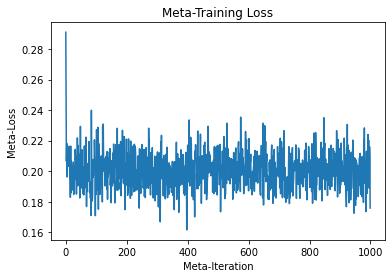

In [46]:
maml.plot_losses()

In [50]:
bandit = Bandit(3)
task_test = BanditTask(bandit())

x,y = [], []
for i in range(nb_arms):
    x.append(i)
    y.append(bandit.step(i))
x, y = torch.Tensor(x).unsqueeze(1), torch.Tensor(y)

TypeError: 'Bandit' object is not callable

In [51]:
# 1000 meta-training steps

print("Real output: {} \n prediction: {} ".format(y, maml.output(x)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x)))

losses = []
for i in range(100):
    losses.append(maml.training(x, y))

print("prediction after 100 training step: {} ".format(maml.output(x)))

NameError: name 'y' is not defined

In [232]:
print("Real output: {} \n prediction: {} ".format(y, maml.output(x)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x)))

losses_1 = []
for i in range(120):
    losses_1.append(maml.training(x, y))

print("prediction after 120 training step: {} ".format(maml.output(x)))

losses_2 = []
for i in range(30):
    losses_2.append(maml.training(x, y))
    
print("prediction after 150 training step: {} ".format(maml.output(x)))

Real output: tensor([11.1171, -0.3937, 11.4129]) 
 prediction: tensor([[6.4834],
        [3.4910],
        [6.5842]], grad_fn=<AddmmBackward>) 
prediction after one training step: tensor([[6.5041],
        [3.5015],
        [6.5644]], grad_fn=<AddmmBackward>) 
prediction after 120 training step: tensor([[10.5630],
        [ 0.1628],
        [10.0102]], grad_fn=<AddmmBackward>) 
prediction after 150 training step: tensor([[10.8457],
        [-0.0382],
        [10.5133]], grad_fn=<AddmmBackward>) 


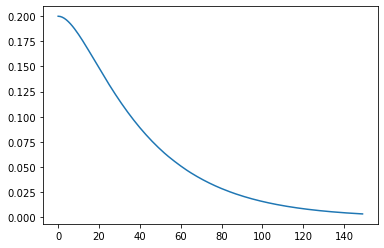

In [233]:
plt.plot(losses_1+losses_2)

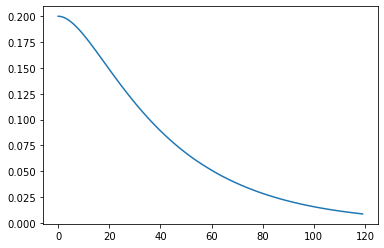

In [234]:
plt.plot(losses_1)

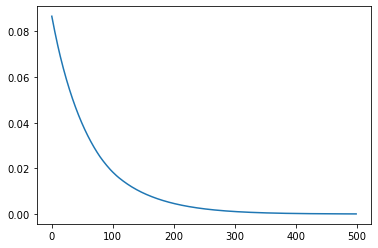

In [90]:
#500 iterations
plt.plot(losses_1+losses_2)

## 1 Meta-training epoch

Funny curve with 0.01 variance for the rewards and 1000 training iterations.

In [103]:
# Créer une instance de la classe FMAML
maml = FMAML(FNet(), alpha, beta, k, num_metatasks, num_shots)

# Entraîner l'algorithme MAML
num_epochs = 0
#maml.outer_loop(num_epochs)

In [104]:
bandit = Bandit()
task_test = BanditTask(bandit)

x,y = [], []
for i in range(nb_arms):
    x.append(i)
    y.append(bandit.step(i))
x, y = torch.Tensor(x).unsqueeze(1), torch.Tensor(y)

In [105]:
print("Real output: {} \n prediction: {} ".format(y, maml.output(x)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x)))

losses_1 = []
for i in range(120):
    losses_1.append(maml.training(x, y))

print("prediction after 120 training step: {} ".format(maml.output(x)))

losses_2 = []
for i in range(30):
    losses_2.append(maml.training(x, y))
    
print("prediction after 150 training step: {} ".format(maml.output(x)))

Real output: tensor([ 0.9285,  8.4799, -1.9825]) 
 prediction: tensor([[0.2095],
        [0.2548],
        [0.2780]], grad_fn=<AddmmBackward>) 
prediction after one training step: tensor([[0.2381],
        [0.2986],
        [0.3297]], grad_fn=<AddmmBackward>) 
prediction after 120 training step: tensor([[3.0508],
        [3.5796],
        [0.5687]], grad_fn=<AddmmBackward>) 
prediction after 150 training step: tensor([[ 3.4957],
        [ 4.4096],
        [-0.1813]], grad_fn=<AddmmBackward>) 


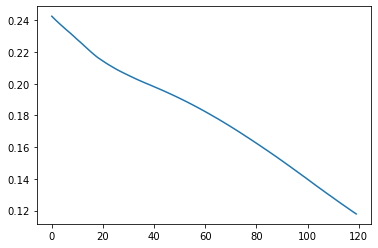

In [106]:
plt.plot(losses_1)

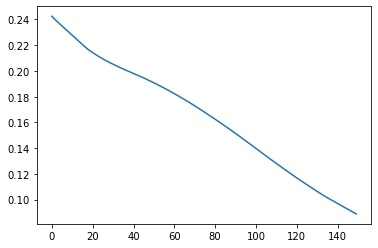

In [107]:
plt.plot(losses_1+losses_2)

# Random variance

## 1000 meta-training epochs

In [388]:
# Créer une instance de la classe FMAML
maml = FMAML(FNet(), alpha, beta, k, num_metatasks, num_shots)

# Entraîner l'algorithme MAML
num_epochs = 10000
maml.outer_loop(num_epochs)

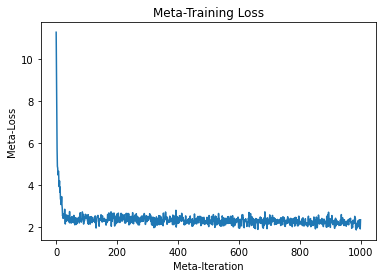

In [389]:
maml.plot_losses()

In [428]:
bandit = Bandit()
task_test = BanditTask(bandit)

x,y = [], []
for i in range(nb_arms):
    x.append(i)
    y.append(bandit.step(i))
x, y = torch.Tensor(x).unsqueeze(1), torch.Tensor(y)

In [429]:
means = [bandit.step(1), bandit.step(2), bandit.step(3)]
for i in range(99):
    means[0] += bandit.step(1)
    means[1]+= bandit.step(2)
    means[2] += bandit.step(3)
means = np.array(means)/100

In [430]:
print(means)

[ 9.13877413 12.65313345  8.89959557]


In [431]:
# 20000 training steps

print("Real output: {} \n prediction: {} ".format(y, maml.output(x,y)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x,y)))

losses_1 = []
for i in range(100):
    losses_1.append(maml.training(x, y))

print("prediction after 100 training step: {} ".format(maml.output(x,y)))

losses_2 = []
for i in range(100):
    losses_2.append(maml.training(x, y))
    
print("prediction after 200 training step: {} ".format(maml.output(x,y)))

losses_3 = []
for i in range(100):
    losses_3.append(maml.training(x, y))
    
print("prediction after 300 training step: {} ".format(maml.output(x,y)))

losses_4 = []
for i in range(100):
    losses_4.append(maml.training(x, y))
    
print("prediction after 400 training step: {} ".format(maml.output(x,y)))

Real output: tensor([ 6.2308,  8.5074, 12.6779]) 
 prediction: tensor([[ 2.8674],
        [11.5199],
        [ 8.6349]], grad_fn=<AbsBackward>) 
prediction after one training step: tensor([[ 2.8128],
        [11.4524],
        [ 8.4215]], grad_fn=<AbsBackward>) 
prediction after 100 training step: tensor([[1.6055],
        [1.7142],
        [0.6176]], grad_fn=<AbsBackward>) 
prediction after 200 training step: tensor([[1.0397],
        [1.4405],
        [0.5998]], grad_fn=<AbsBackward>) 
prediction after 300 training step: tensor([[0.8440],
        [1.1809],
        [0.4483]], grad_fn=<AbsBackward>) 
prediction after 400 training step: tensor([[0.6888],
        [0.9495],
        [0.3757]], grad_fn=<AbsBackward>) 


In [432]:
print(9/8, 10.1/8, 6.6/8)

1.125 1.2625 0.825


In [423]:
for i in range(1000):
    maml.training(x, y)
    
print("prediction after 1000 training step: {} ".format(maml.output(x,y)))

prediction after 1000 training step: tensor([[6.6757e-06],
        [5.7220e-06],
        [9.5367e-07]], grad_fn=<AbsBackward>) 


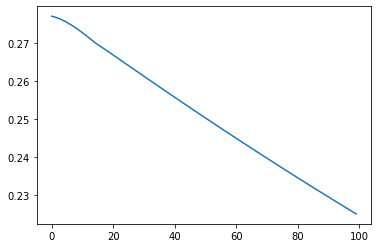

In [379]:
plt.plot(losses_1)

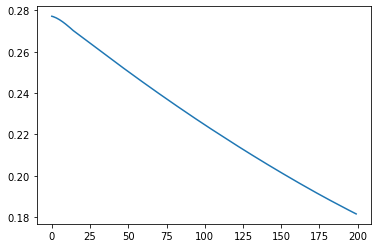

In [380]:
plt.plot(losses_1+losses_2)

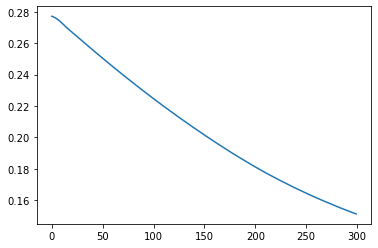

In [381]:
plt.plot(losses_1+losses_2+losses_3)

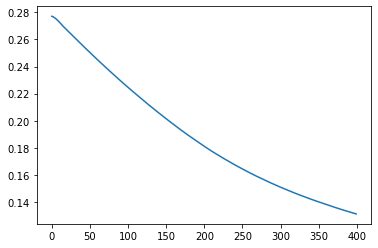

In [382]:
plt.plot(losses_1+losses_2+losses_3+losses_4)

## NO meta-training epoch

In [456]:
# Créer une instance de la classe FMAML
maml = FMAML(FNet(), alpha, beta, k, num_metatasks, num_shots)

# Entraîner l'algorithme MAML
num_epochs = 0
#maml.outer_loop(num_epochs)

In [457]:
bandit = Bandit()
task_test = BanditTask(bandit)

x,y = [], []
for i in range(nb_arms):
    x.append(i)
    y.append(bandit.step(i))
x, y = torch.Tensor(x).unsqueeze(1), torch.Tensor(y)

In [458]:
print("Real output: {} \n prediction: {} ".format(y, maml.output(x,y)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x,y)))

losses_1 = []
for i in range(100):
    losses_1.append(maml.training(x, y))

print("prediction after 100 training step: {} ".format(maml.output(x,y)))

losses_2 = []
for i in range(100):
    losses_2.append(maml.training(x, y))
    
print("prediction after 200 training step: {} ".format(maml.output(x,y)))

losses_3 = []
for i in range(100):
    losses_3.append(maml.training(x, y))
    
print("prediction after 300 training step: {} ".format(maml.output(x,y)))

losses_4 = []
for i in range(100):
    losses_4.append(maml.training(x, y))
    
print("prediction after 400 training step: {} ".format(maml.output(x,y)))

Real output: tensor([ 2.8877, 22.5018, 21.4048]) 
 prediction: tensor([[ 2.6870],
        [22.1156],
        [20.7873]], grad_fn=<AbsBackward>) 
prediction after one training step: tensor([[ 2.6620],
        [22.0816],
        [20.7418]], grad_fn=<AbsBackward>) 
prediction after 100 training step: tensor([[ 3.5605],
        [12.2285],
        [ 6.1108]], grad_fn=<AbsBackward>) 
prediction after 200 training step: tensor([[4.5881],
        [6.6716],
        [2.6361]], grad_fn=<AbsBackward>) 
prediction after 300 training step: tensor([[2.6593],
        [6.1642],
        [3.1563]], grad_fn=<AbsBackward>) 
prediction after 400 training step: tensor([[1.6408],
        [5.5078],
        [3.1525]], grad_fn=<AbsBackward>) 


In [459]:
print(48.5/8, 43/8, 28.5/8)

6.0625 5.375 3.5625


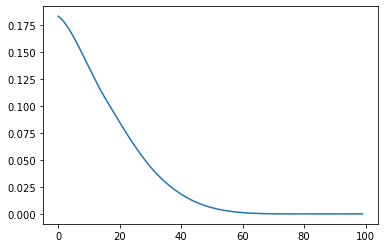

In [441]:
plt.plot(losses_1)

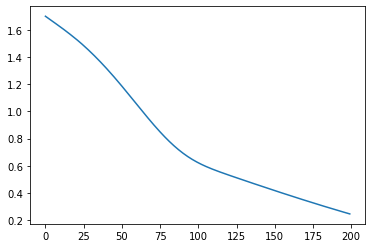

In [355]:
plt.plot(losses_1+losses_2)

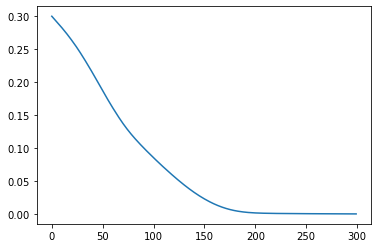

In [202]:
plt.plot(losses_1+losses_2+losses_3)

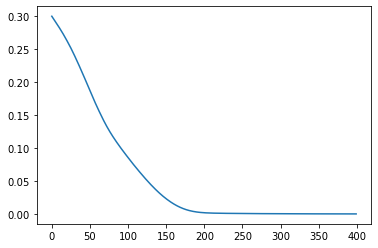

In [203]:
plt.plot(losses_1+losses_2+losses_3+losses_4)

# To try Bayesian MAML

In [ ]:
    def ML_point(self, task,k):
        temp_weights=[w.clone() for w in self.weights]  #This is phi
        x,y=task.sample_data(size=self.k) #sampling D
        x=x.to(device)
        y=y.to(device)
        for i in range(10):
            output=self.net.argforward(x,temp_weights) #We get f(x)
            loss=self.criterion(output, y, torch.ones_like(y))  #nn.GaussianNLLLoss(y, output)    
            grads=torch.autograd.grad(loss,temp_weights)  #allow_unused=True
            temp_weights = [w-self.alpha*g for w,g in zip(temp_weights,grads)]
        x_new, y_new = task.sample_data(size=self.m)
        x_new.to(device)
        y_new.to(device)
        output = self.net.argforward(x_new,temp_weights)
        metaloss = self.criterion(output, y_new, torch.ones_like(output))  #  -np.log(norm.pdf(y_new, loc=output))
        return metaloss